#### =============================================================================
### Copyright 2025. Somjit Roy and Pritam Dey. 
### This program implements the TAVIE algorithm as developed in:
### Roy, S., Dey, P., Pati, D., and Mallick, B.K.
### 'A Generalized Tangent Approximation Framework for Strongly Super-Gaussian Likelihoods',
### arXiv:2504.05431 <https://arxiv.org/abs/2504.05431>.
### We compare TAVIE for the Negative-Binomial model against competing methods.
###
### Authors:
###   Somjit Roy (<sroy_123@tamu.edu>) and Pritam Dey (<pritam.dey@tamu.edu>)
#### =============================================================================

This `ipynb` compares the **TAVIE** algorithm to different state-of-the-art variational algorithms applied under Negative-Binomial SSG likleihood.
* **Negative-Binomial SSG**: `TAVIE` versus `ADVI mean-field`, `ADVI full-rank`, `DADVI` and `NUTS`.

In [1]:
# Required for DADVI experiments, running TAVIE and other BBVI algorithms
import pymc as pm
import pytensor
import pytensor.tensor as pt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import jax
import jax.numpy as jnp
setattr(jnp, "product", jnp.prod)
jax.config.update("jax_enable_x64", True)
from CompetingMethods import *
from dadvi.pymc.jax_api import fit_pymc_dadvi_with_jax
from TAVIE import *
import rich
from sklearn.preprocessing import scale
from IPython.display import display, Latex
from time import perf_counter
from tqdm import tqdm, trange
from scipy.stats import t
import arviz as az
import re

### True synthetic Negative-Binomial data generation, n=10000, p=5 (+ intercept)

In [2]:
# Simulated data
n = 10000
p = 5
r = 20
beta_true = np.random.normal(loc=0.0, scale=0.5, size=p+1)

# Design matrix, true regression coefficients and response
X = np.random.normal(size=(n, p))
X_bbvi = np.column_stack((np.ones(n), X))
linear_term  = beta_true[0] + X @ beta_true[1:len(beta_true)] 
probs = 1 / (1 + np.exp(-linear_term))
y = np.random.negative_binomial(r, probs, size=n)

### Code for the Negative-Binomial PyMC model and fitting Negative-Binomial NUTS model || Also fitting the TAVIE Negative-Binomial model || Fitting ADVI algorithms

In [3]:
def negbin_pymc_model(X, y, r):
    """
    Negative Binomial regression:
        y ~ NB(n=r, p = sigmoid(X @ beta))
    which is equivalent to mean mu = r * exp(-X @ beta).

    r: float or array-like of length n. If float, it's broadcast to length n.
    """
    # ensure arrays & shapes
    X = np.asarray(X)
    y = np.asarray(y)
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    n, p = X.shape

    # counts must be non-negative integers
    if not np.issubdtype(y.dtype, np.integer):
        y = y.astype(np.int64)

    # handle r: float -> length-n vector; array -> validate length
    if np.isscalar(r):
        r_vec = np.full(n, float(r))
    else:
        r_vec = np.asarray(r, dtype=float).reshape(-1)
        if r_vec.size != n:
            raise ValueError(f"r must be scalar or length n={n}, got {r_vec.size}")
    if np.any(r_vec <= 0):
        raise ValueError("All entries of r must be > 0")

    fxdtype = np.dtype(pytensor.config.floatX)

    with pm.Model() as model:
        # data
        X_data = pm.MutableData("X", X.astype(fxdtype))
        y_data = pm.MutableData("y", y)
        r_data = pm.MutableData("r", r_vec.astype(fxdtype))

        # prior on beta
        beta = pm.Normal("beta", mu=0.0, sigma=1.0, shape=p)

        # linear predictor & link
        eta = pt.dot(X_data, beta)                 # shape (n,)
        p_nb = pm.math.sigmoid(eta)                # p in (0,1)
        mu   = pm.Deterministic("mu", r_data * pt.exp(-eta))  # for inspection

        # NB likelihood with (n=r, p=sigmoid(Xβ))
        pm.NegativeBinomial("y_obs", n=r_data, p=p_nb, observed=y_data)

    return model


def fit_NUTS_negbin(model):
    """
    Fit the NB model (with known r) using NUTS and return posterior means for beta.
    """
    import logging, warnings
    logging.getLogger("pymc").setLevel(logging.ERROR)
    logging.getLogger("pytensor").setLevel(logging.ERROR)
    warnings.filterwarnings("ignore", message=r"os\.fork\(\) was called", category=RuntimeWarning)

    with model:
        idata = pm.sample(progressbar=False, compute_convergence_checks=False)

    summ = az.summary(idata, var_names=["beta"])[["mean"]]

    # beta mean (scalar or vector)
    beta_rows = summ[summ.index.str.startswith("beta")]
    if len(beta_rows) == 1 and beta_rows.index[0] == "beta":
        beta_mean = float(beta_rows["mean"].iloc[0])
    else:
        def _idx(name):
            m = re.match(r"beta\[(\d+)\]", name)
            return int(m.group(1)) if m else 0
        beta_mean = (
            beta_rows.assign(_i=beta_rows.index.map(_idx))
                     .sort_values("_i")["mean"]
                     .to_numpy()
        )

    return {"beta": np.array(beta_mean)}


In [4]:
# Initialize NB PyMC model for DADVI
negbin_dadvi_model = negbin_pymc_model(X_bbvi, y, r=r)

# Initialize the NB TAVIE model
negbin_tavie_model = TAVIE_type_II(family="negbin", fit_intercept=True)

# Now fit DADVI
negbin_dadvi_res = fit_pymc_dadvi_with_jax(negbin_dadvi_model, num_fixed_draws=30).get_posterior_means()

# Now fitting and obtaining results from the NUTS NB model
negbin_nuts_res = fit_NUTS_negbin(negbin_dadvi_model)

# Now fitting the TAVIE model for NB regression
negbin_tavie_model.fit(X, y, r=r, verbose=False)
negbin_tavie_res = negbin_tavie_model.get_TAVIE_means(verbose=False)

# Now fitting ADVI mean-field (BBVI) and ADVI full-rank (BBVI fullcov)
negbin_advi_mf_res = BBVI_NegBin_patience_best(X_bbvi, y, r=r, lr=1e-3, tol=1e-9, patience=1e4, verbose=False)
negbin_advi_fr_res = BBVI_NegBin_fullcov_AdamW_best(X_bbvi, y, r=r, Sigma_prior=np.eye(p+1), lr=1e-3, tol=1e-9, patience=1e4, verbose=False)

### TAVIE, DADVI, ADVI, and NUTS Results

In [5]:
print("################################")
print("-----------Ground Truth---------")
print("################################")
print(f"beta={beta_true}")

print("\n")

print("################################")
print("-----------TAVIE results---------")
print("################################")
print(f"beta.est={negbin_tavie_res}")

print("\n")

print("################################")
print("-----------DADVI results---------")
print("################################")
print(f"beta.est={negbin_dadvi_res['beta']}")

print("\n")

print("################################")
print("-----------ADVI mean-field results---------")
print("################################")
print(f"beta.est={negbin_advi_mf_res['beta_mean']}")

print("\n")

print("################################")
print("-----------ADVI full-rank results---------")
print("################################")
print(f"beta.est={negbin_advi_fr_res['beta_mean']}")

print("\n")

print("################################")
print("-----------NUTS results---------")
print("################################")
print(f"beta.est={negbin_nuts_res['beta']}")

################################
-----------Ground Truth---------
################################
beta=[-0.40270224 -0.49839422  0.2560177  -0.44894921  0.41031536  1.06199772]


################################
-----------TAVIE results---------
################################
beta.est=[-0.3980777  -0.49445716  0.25263253 -0.44854145  0.40735406  1.06098195]


################################
-----------DADVI results---------
################################
beta.est=[-0.39825084 -0.49406787  0.2525992  -0.44837589  0.40789493  1.06016011]


################################
-----------ADVI mean-field results---------
################################
beta.est=[-0.3917722  -0.50475746  0.2619134  -0.4594156   0.41452998  1.0727427 ]


################################
-----------ADVI full-rank results---------
################################
beta.est=[-0.39477637 -0.4967072   0.25478724 -0.44543535  0.40679407  1.0607595 ]


################################
-----------NUTS results-----

### For fixed sample size n=1000 and fixed features p=5

In [6]:
# TAVIE model initialization
negbin_tavie_model = TAVIE_type_II(family="negbin", fit_intercept=True)

# Experiment parameters
n = 1000
p = 5
r = 10
num_reps = 100
# True beta vector
beta_true = np.random.normal(loc=0.0, scale=0.5, size=p+1)

# Containers for metrics
mse_beta_ADVI_mf = np.zeros(num_reps)
mse_beta_ADVI_fr = np.zeros(num_reps)
mse_beta_TAVIE = np.zeros(num_reps)
mse_beta_DADVI = np.zeros(num_reps)
mse_beta_NUTS = np.zeros(num_reps)

time_TAVIE = np.zeros(num_reps)
time_ADVI_mf = np.zeros(num_reps)
time_ADVI_fr = np.zeros(num_reps)
time_DADVI = np.zeros(num_reps)
time_NUTS = np.zeros(num_reps)

# prior choice
Sigma_prior = np.eye(p + 1)

# Main loop with progress bar for TAVIE and BBVI results
for rep in trange(num_reps, desc="Repetitions"):
    np.random.seed(rep)
    # Generate synthetic data
    X = np.random.normal(size=(n, p))
    X_bbvi = np.column_stack((np.ones(n), X))
    linear_term  = beta_true[0] + X @ beta_true[1:len(beta_true)] 
    probs = 1 / (1 + np.exp(-linear_term))
    y = np.random.negative_binomial(r, probs, size=n)

    # DADVI estimator
    negbin_dadvi_model = negbin_pymc_model(X_bbvi, y, r=r)
    t0 = perf_counter()
    negbin_dadvi_res = fit_pymc_dadvi_with_jax(negbin_dadvi_model, num_fixed_draws=30).get_posterior_means()
    time_DADVI[rep] = perf_counter() - t0
    beta_est_DADVI = negbin_dadvi_res['beta']
    mse_beta_DADVI[rep] = np.mean((beta_est_DADVI - beta_true)**2)

    # NUTS estimator
    t0 = perf_counter()
    negbin_nuts_res = fit_NUTS_negbin(negbin_dadvi_model)
    time_NUTS[rep] = perf_counter() - t0
    beta_est_NUTS = negbin_nuts_res['beta']
    mse_beta_NUTS[rep] = np.mean((beta_est_NUTS - beta_true)**2)

    # TAVIE estimator
    t0 = perf_counter()
    negbin_tavie_model.fit(X, y, r=r, verbose=False) # fitting the TAVIE model for laplace
    time_TAVIE[rep] = perf_counter() - t0
    beta_est_TAVIE = negbin_tavie_model.get_TAVIE_means(verbose=False) # obtaining the TAVIE estimates
    mse_beta_TAVIE[rep] = np.mean((beta_est_TAVIE - beta_true)**2)

    # ADVI mean-field estimator
    t0 = perf_counter()
    res2 = BBVI_NegBin_patience_best(X_bbvi, y, r=r, lr=1e-3, tol=1e-9, patience=1e4, verbose=False)
    time_ADVI_mf[rep] = perf_counter() - t0
    beta_est_ADVI_mf = res2['beta_mean']
    mse_beta_ADVI_mf[rep] = np.mean((beta_est_ADVI_mf - beta_true)**2)

    # ADVI full-rank estimator
    t0 = perf_counter()
    res3 = BBVI_NegBin_fullcov_AdamW_best(X_bbvi, y, r=r, Sigma_prior=Sigma_prior, lr=1e-3, tol=1e-9, patience=1e4, verbose=False)
    time_ADVI_fr[rep] = perf_counter() - t0
    beta_est_ADVI_fr = res3['beta_mean']
    mse_beta_ADVI_fr[rep] = np.mean((beta_est_ADVI_fr - beta_true)**2)

# saving the metrics
import pickle

# collect everything into a single dict
metrics_df = {
    'p'            :       p,
    'n'            :       n,
    'mse_beta_TAVIE':     mse_beta_TAVIE,
    'time_TAVIE':         time_TAVIE,
    'mse_beta_ADVI_mf':      mse_beta_ADVI_mf,
    'time_ADVI_mf':          time_ADVI_mf,
    'mse_beta_ADVI_fr':      mse_beta_ADVI_fr,
    'time_ADVI_fr':          time_ADVI_fr,
    'mse_beta_DADVI':      mse_beta_DADVI,
    'time_DADVI':          time_DADVI,
    'mse_beta_NUTS':      mse_beta_NUTS,
    'time_NUTS':          time_NUTS,
}

# write to disk
with open(f'results_compete/NegBin_metrics_n_{n}_p_{p}.pkl', 'wb') as f:
    pickle.dump(metrics_df, f, protocol=pickle.HIGHEST_PROTOCOL)

Repetitions: 100%|█████████████████████| 100/100 [22:32<00:00, 13.52s/it]


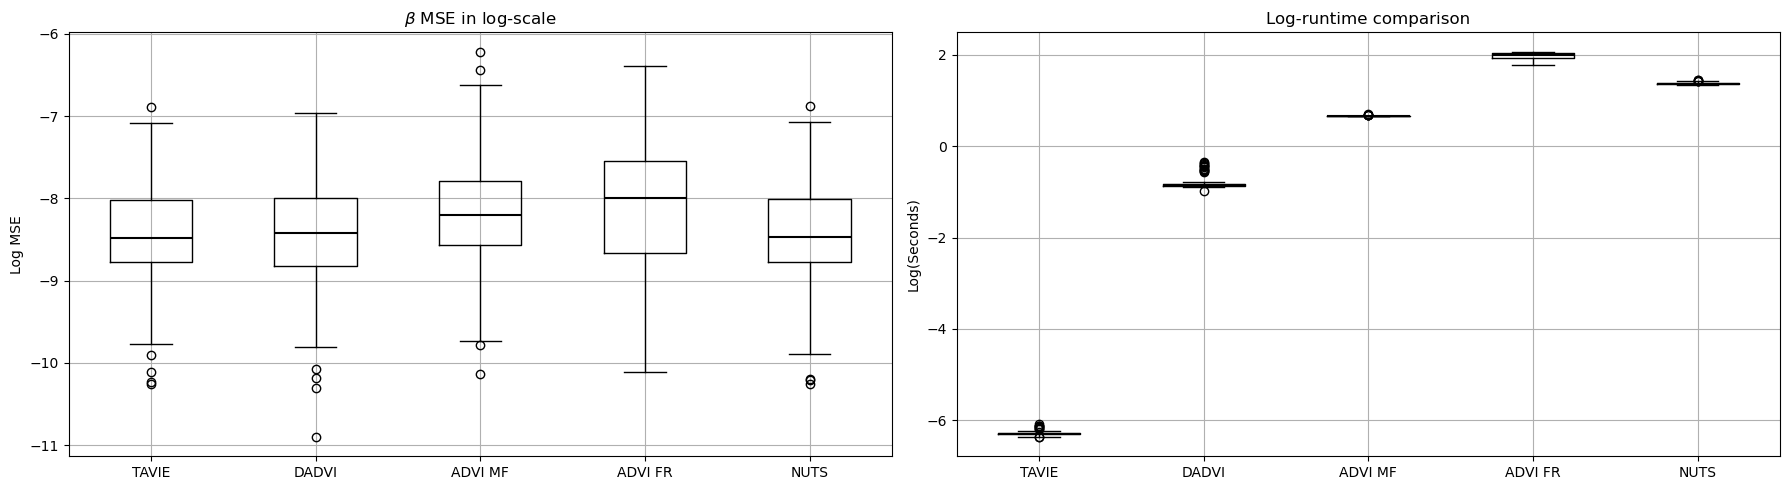

In [7]:
# plotting the results for TAVIE, DADVI, BBVI, and NUTS

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
median_kws = dict(color='black', linewidth=1.5)

# Beta MSE comparison
axes[0].boxplot([np.log(mse_beta_TAVIE), np.log(mse_beta_DADVI), np.log(mse_beta_ADVI_mf), 
                 np.log(mse_beta_ADVI_fr), np.log(mse_beta_NUTS)], 
                tick_labels=['TAVIE', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS'], medianprops=median_kws)
axes[0].set_title(r'$\beta$ MSE in log-scale')
axes[0].set_ylabel('Log MSE')
axes[0].grid(True)

# Runtime comparison
axes[1].boxplot([np.log(time_TAVIE), np.log(time_DADVI), np.log(time_ADVI_mf), np.log(time_ADVI_fr), np.log(time_NUTS)], 
                tick_labels=['TAVIE', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS'], medianprops=median_kws)
axes[1].set_title('Log-runtime comparison')
axes[1].set_ylabel('Log(Seconds)')
axes[1].grid(True)

plt.tight_layout()
fig.savefig(f'results_compete/plots/NegBin_metrics_n_{n}_p_{p}.png', dpi=300, bbox_inches='tight')
plt.show()

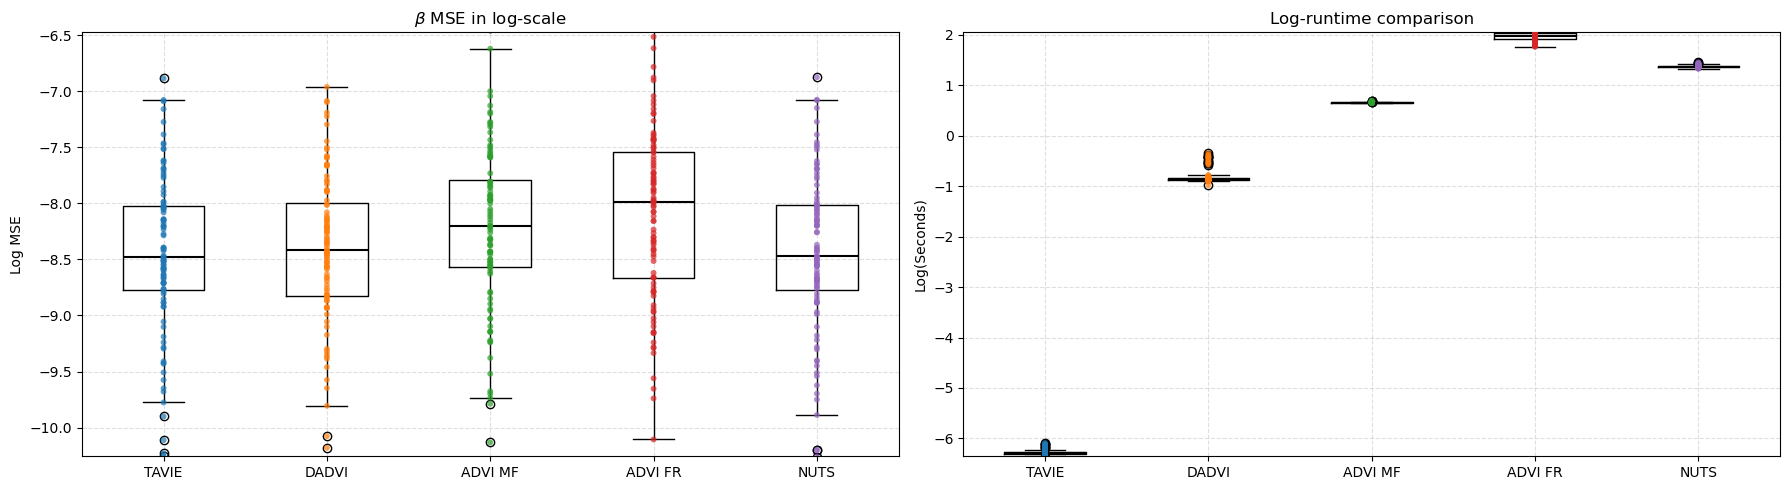

In [8]:
# plotting the results for TAVIE, DADVI, BBVI, and NUTS

labels = ['TAVIE', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS']
eps = 1e-16  # avoid log(0)

# prepare log-data (original values, no jitter)
beta_logs = [np.log(np.clip(np.asarray(a), eps, None)) for a in
             [mse_beta_TAVIE, mse_beta_DADVI, mse_beta_ADVI_mf, mse_beta_ADVI_fr, mse_beta_NUTS]]
time_logs = [np.log(np.clip(np.asarray(a), eps, None)) for a in
             [time_TAVIE, time_DADVI, time_ADVI_mf, time_ADVI_fr, time_NUTS]]

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
median_kws = dict(color='black', linewidth=1.5)

# --- β MSE ---
axes[0].boxplot(beta_logs, tick_labels=labels, medianprops=median_kws)
axes[0].set_title(r'$\beta$ MSE in log-scale')
axes[0].set_ylabel('Log MSE')
axes[0].grid(True, linestyle='--', alpha=0.4)
for i, y in enumerate(beta_logs, start=1):
    x = np.full(y.shape, i, dtype=float)
    axes[0].scatter(x, y, s=18, alpha=0.7, zorder=3, edgecolors='none')

# --- Runtime ---
axes[1].boxplot(time_logs, tick_labels=labels, medianprops=median_kws)
axes[1].set_title('Log-runtime comparison')
axes[1].set_ylabel('Log(Seconds)')
axes[1].grid(True, linestyle='--', alpha=0.4)
for i, y in enumerate(time_logs, start=1):
    x = np.full(y.shape, i, dtype=float)
    axes[1].scatter(x, y, s=18, alpha=0.7, zorder=3, edgecolors='none')

# optional: robust y-limits so tiny spreads aren’t crushed by outliers
for ax, logs in zip(axes, [beta_logs, time_logs]):
    allv = np.concatenate([v for v in logs if len(v)])
    ax.set_ylim(*np.percentile(allv, [0.5, 99.5]))

plt.tight_layout()
fig.savefig(f'results_compete/plots/NegBin_metrics_n_{n}_p_{p}_other.png', dpi=300, bbox_inches='tight')
plt.show()

### For multiple sample sizes n and fixed features p=5

In [9]:
# ==== Experiment settings ====
p = 5
num_reps = 100
r = 10
sample_sizes = [200, 500, 1000, 2000]     # <-- your various n’s here

# True beta vector
beta_true = np.random.normal(loc=0.0, scale=0.5, size=p+1)

# Prior for full‐cov BBVI
Sigma_prior = np.eye(p + 1)

# Pre‐allocate storage: shape (len(sample_sizes), num_reps)
n_sizes = len(sample_sizes)
mse_beta_TAVIE          = np.zeros((n_sizes, num_reps))
time_TAVIE              = np.zeros((n_sizes, num_reps))

mse_beta_DADVI          = np.zeros((n_sizes, num_reps))
time_DADVI              = np.zeros((n_sizes, num_reps))

mse_beta_NUTS          = np.zeros((n_sizes, num_reps))
time_NUTS              = np.zeros((n_sizes, num_reps))

mse_beta_ADVI_mf           = np.zeros((n_sizes, num_reps))
time_ADVI_mf               = np.zeros((n_sizes, num_reps))

mse_beta_ADVI_fr   = np.zeros((n_sizes, num_reps))
time_ADVI_fr       = np.zeros((n_sizes, num_reps))

# TAVIE model initialization
negbin_tavie_model = TAVIE_type_II(family="negbin", fit_intercept=True)

# ==== Main loops ====
for i, n in enumerate(sample_sizes):
    for rep in trange(num_reps, desc=f"n={n}"):
        np.random.seed(rep)
        # Generate synthetic data
        X = np.random.normal(size=(n, p))
        X_bbvi = np.column_stack((np.ones(n), X))
        linear_term  = beta_true[0] + X @ beta_true[1:len(beta_true)] 
        probs = 1 / (1 + np.exp(-linear_term))
        y = np.random.negative_binomial(r, probs, size=n)

        # ---- TAVIE ----
        t0 = perf_counter()
        negbin_tavie_model.fit(X, y, r=r, verbose=False)
        time_TAVIE[i, rep] = perf_counter() - t0
        beta_est_TAVIE = negbin_tavie_model.get_TAVIE_means(verbose=False)
        mse_beta_TAVIE[i, rep] = np.mean((beta_est_TAVIE - beta_true)**2)


        # DADVI estimator
        negbin_dadvi_model = negbin_pymc_model(X_bbvi, y, r=r)
        t0 = perf_counter()
        negbin_dadvi_res = fit_pymc_dadvi_with_jax(negbin_dadvi_model, num_fixed_draws=30).get_posterior_means()
        time_DADVI[i, rep] = perf_counter() - t0
        beta_est_DADVI = negbin_dadvi_res['beta']
        mse_beta_DADVI[i, rep] = np.mean((beta_est_DADVI - beta_true)**2)
    
        # NUTS estimator
        t0 = perf_counter()
        negbin_nuts_res = fit_NUTS_negbin(negbin_dadvi_model)
        time_NUTS[i, rep] = perf_counter() - t0
        beta_est_NUTS = negbin_nuts_res['beta']
        mse_beta_NUTS[i, rep] = np.mean((beta_est_NUTS - beta_true)**2)

        # ADVI mean-field estimator
        t0 = perf_counter()
        res2 = BBVI_NegBin_patience_best(X_bbvi, y, r=r, lr=1e-3, tol=1e-9, patience=1e4, verbose=False)
        time_ADVI_mf[i, rep] = perf_counter() - t0
        beta_est_ADVI_mf = res2['beta_mean']
        mse_beta_ADVI_mf[i, rep] = np.mean((beta_est_ADVI_mf - beta_true)**2)
    
        # ADVI full-rank estimator
        t0 = perf_counter()
        res3 = BBVI_NegBin_fullcov_AdamW_best(X_bbvi, y, r=r, Sigma_prior=Sigma_prior, lr=1e-3, tol=1e-9, patience=1e4, verbose=False)
        time_ADVI_fr[i, rep] = perf_counter() - t0
        beta_est_ADVI_fr = res3['beta_mean']
        mse_beta_ADVI_fr[i, rep] = np.mean((beta_est_ADVI_fr - beta_true)**2)

# saving the metrics
import pickle

# collect everything into a single dict
metrics_df = {
    'p'            :       p,
    'n'            :       sample_sizes,
    'mse_beta_TAVIE':     mse_beta_TAVIE,
    'time_TAVIE':         time_TAVIE,
    'mse_beta_ADVI_mf':      mse_beta_ADVI_mf,
    'time_ADVI_mf':          time_ADVI_mf,
    'mse_beta_ADVI_fr':      mse_beta_ADVI_fr,
    'time_ADVI_fr':          time_ADVI_fr,
    'mse_beta_DADVI':      mse_beta_DADVI,
    'time_DADVI':          time_DADVI,
    'mse_beta_NUTS':      mse_beta_NUTS,
    'time_NUTS':          time_NUTS,
}

# write to disk
with open(f'results_compete/NegBin_metrics_multi_n_p_{p}.pkl', 'wb') as f:
    pickle.dump(metrics_df, f, protocol=pickle.HIGHEST_PROTOCOL)

n=2000: 100%|██████████████████████████| 100/100 [25:34<00:00, 15.35s/it]


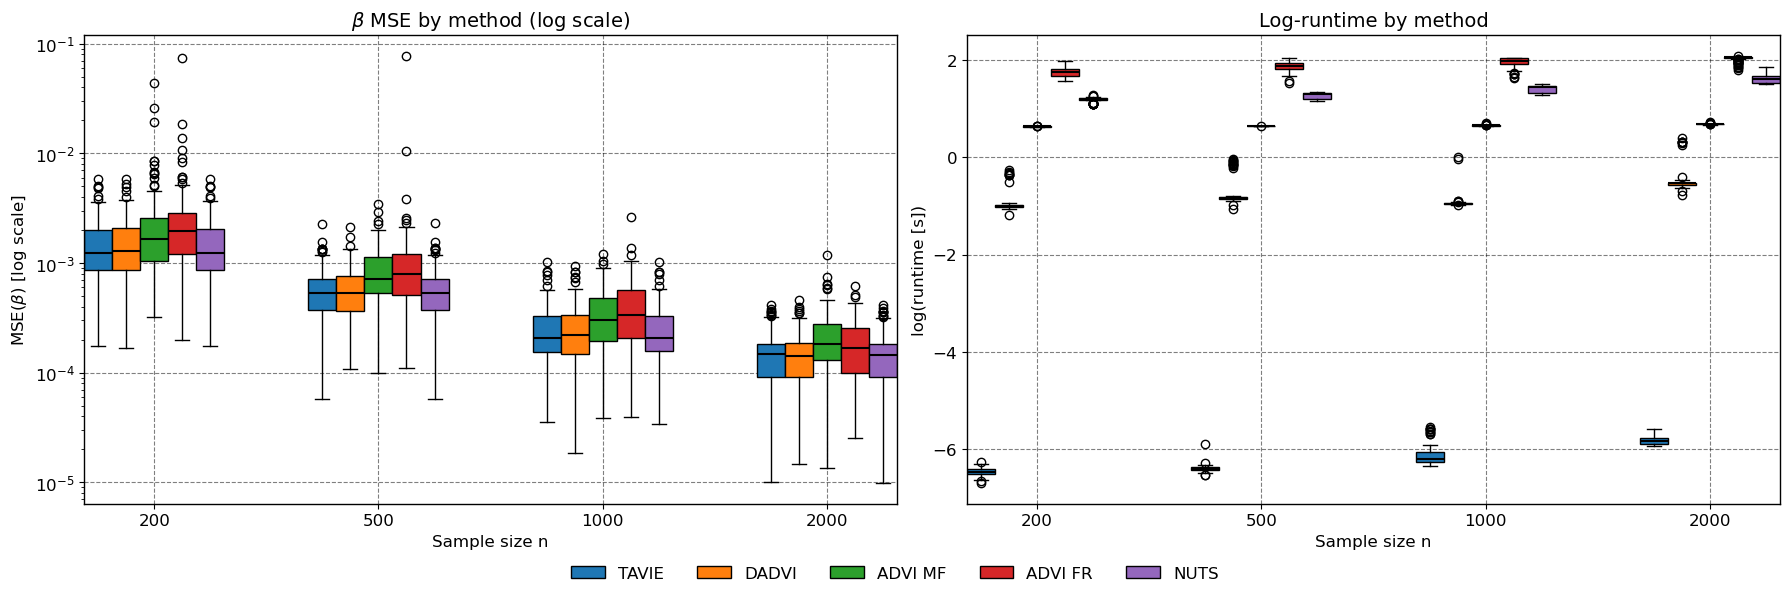

In [10]:
# plotting the results for TAVIE, DADVI, ADVI, and NUTS over the choice of different sample sizes n

methods  = ['TAVIE', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS']
colors   = ['C0',    'C1',    'C2', 'C3', 'C4']
n_sizes  = len(sample_sizes)
x        = np.arange(n_sizes)
width    = 0.2

# --- spacing controls ---
M             = len(methods)
group_spacing = 8.0   # gap between n-groups on x-axis
method_step   = 1.0  # separation between methods within a group
box_width     = 1.0  # width of each box
centers       = np.arange(n_sizes) * group_spacing

fig, axes = plt.subplots(1, 2, figsize=(18, 6), facecolor='white')
median_kws = dict(color='black', linewidth=1.5)

# Configure axes background, spines, ticks, and grid
for ax in axes:
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(1.0)
    ax.tick_params(axis='both', colors='black', labelsize=12)
    ax.grid(True, color='black', linestyle='--', alpha=0.5)

# 2) β MSE (log scale)
ax = axes[0]
for j, arr in enumerate([mse_beta_TAVIE, mse_beta_DADVI, mse_beta_ADVI_mf, mse_beta_ADVI_fr, mse_beta_NUTS]):
    data = [arr[i, :] for i in range(n_sizes)]
    positions = centers + (j - (M-1)/2) * method_step
    bp = ax.boxplot(data, positions=positions, widths=box_width,
                    patch_artist=True, medianprops=median_kws)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')
ax.set_xticks(centers)
ax.set_xticklabels(sample_sizes)
ax.set_yscale('log')
ax.set_xlabel('Sample size n', color='black', fontsize=12)
ax.set_ylabel(r'MSE($\beta$) [log scale]', color='black', fontsize=12)
ax.set_title(r'$\beta$ MSE by method (log scale)', color='black', fontsize=14)

# 3) Runtime (log scale on the data)
ax = axes[1]
for j, arr in enumerate([time_TAVIE, time_DADVI, time_ADVI_mf, time_ADVI_fr, time_NUTS]):
    data = [np.log(arr[i, :]) for i in range(n_sizes)]
    positions = centers + (j - (M-1)/2) * method_step
    bp = ax.boxplot(data, positions=positions, widths=box_width, patch_artist=True, medianprops=median_kws)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')
ax.set_xticks(centers)
ax.set_xticklabels(sample_sizes)
ax.set_xlabel('Sample size n', color='black', fontsize=12)
ax.set_ylabel('log(runtime [s])', color='black', fontsize=12)
ax.set_title('Log-runtime by method', color='black', fontsize=14)

# Common legend below
handles = [Patch(facecolor=colors[i], edgecolor='black', label=methods[i]) for i in range(len(methods))]
fig.legend(handles=handles, loc='lower center', ncol=5, frameon=False, fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 1])
fig.savefig(f'results_compete/plots/NegBin_metrics_multi_n_p_{p}.png', dpi=300, bbox_inches='tight')
plt.show()


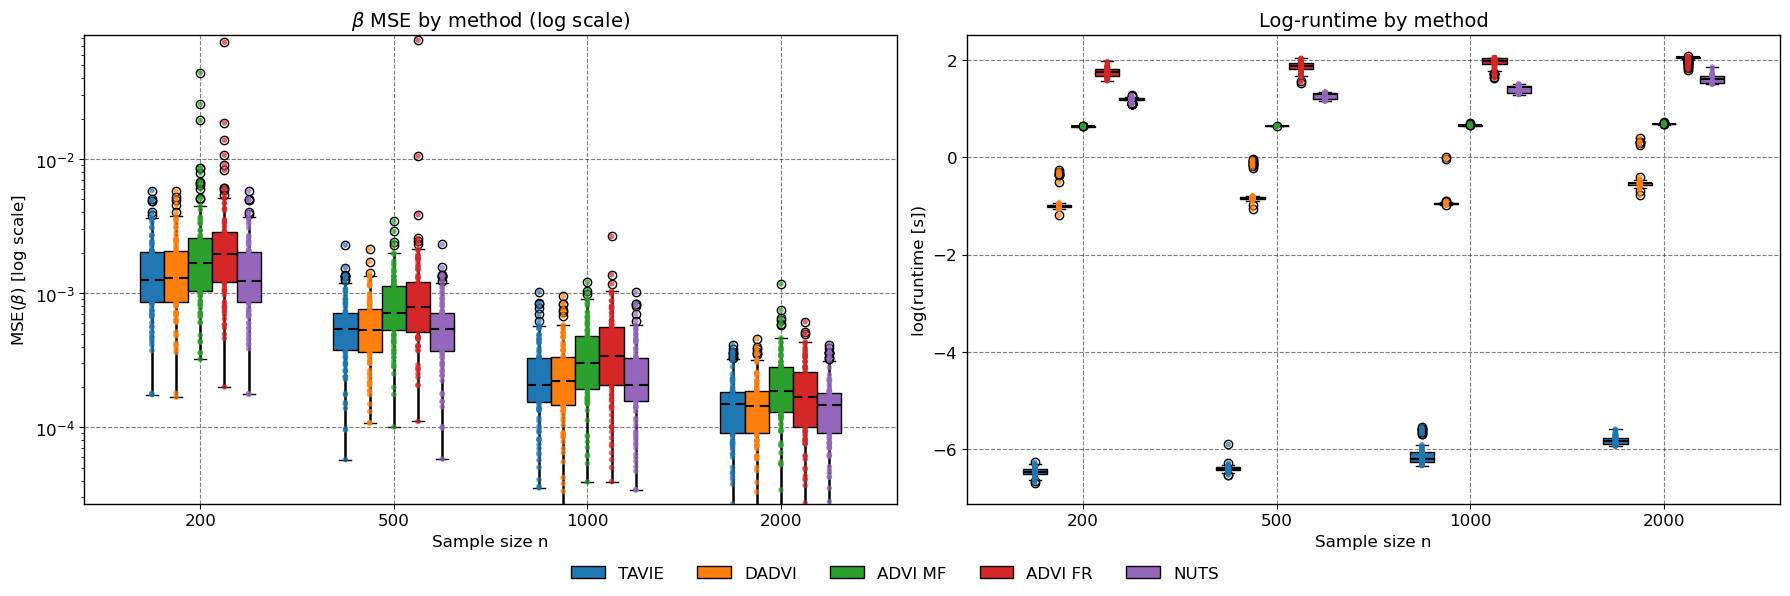

In [11]:
# plotting the results for TAVIE, DADVI, ADVI, and NUTS over different sample sizes n

methods  = ['TAVIE', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS']
colors   = ['C0',    'C1',    'C2',     'C3',      'C4']
n_sizes  = len(sample_sizes)
M        = len(methods)
eps      = 1e-16  # avoid log(0) in log-scale panels

# --- spacing controls ---
group_spacing = 8.0    # gap between n-groups on x-axis
method_step   = 1      # separation between methods within a group
box_width     = 1      # width of each box
centers       = np.arange(n_sizes) * group_spacing

fig, axes = plt.subplots(1, 2, figsize=(18, 6), facecolor='white')

# Configure axes background, spines, ticks, and grid
for ax in axes:
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_color('black'); spine.set_linewidth(1.0)
    ax.tick_params(axis='both', colors='black', labelsize=12)
    ax.grid(True, color='black', linestyle='--', alpha=0.5)

# Common boxplot style (no end caps)
bp_kwargs = dict(
    widths=box_width,
    patch_artist=True,
    whiskerprops=dict(linewidth=1.8, color='black'),
    medianprops=dict(linewidth=1.5, color='black'),
)

# 2) β MSE (log axis)
ax = axes[0]
all_vals_beta = []
series_beta = [mse_beta_TAVIE, mse_beta_DADVI, mse_beta_ADVI_mf, mse_beta_ADVI_fr, mse_beta_NUTS]
for j, arr in enumerate(series_beta):
    data = [np.clip(arr[i, :], eps, None) for i in range(n_sizes)]
    positions = centers + (j - (M-1)/2) * method_step
    bp = ax.boxplot(data, positions=positions, **bp_kwargs)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')
    # overlay original values (clipped)
    for i in range(n_sizes):
        pos = positions[i]
        yvals = np.clip(np.asarray(arr[i, :]), eps, None)
        ax.scatter(np.full_like(yvals, pos, dtype=float), yvals,
                   s=16, alpha=0.7, color=colors[j], zorder=3, edgecolors='none')
        all_vals_beta.append(yvals)

ax.set_xticks(centers); ax.set_xticklabels(sample_sizes)
ax.set_yscale('log')
ax.set_xlabel('Sample size n', fontsize=12)
ax.set_ylabel(r'MSE($\beta$) [log scale]', fontsize=12)
ax.set_title(r'$\beta$ MSE by method (log scale)', fontsize=14)
ax.set_xlim(centers[0] - group_spacing*0.6, centers[-1] + group_spacing*0.6)

# 3) Runtime (log on the DATA; linear axis)
ax = axes[1]
all_vals_time = []
series_time = [time_TAVIE, time_DADVI, time_ADVI_mf, time_ADVI_fr, time_NUTS]
for j, arr in enumerate(series_time):
    data = [np.log(np.clip(arr[i, :], eps, None)) for i in range(n_sizes)]
    positions = centers + (j - (M-1)/2) * method_step
    bp = ax.boxplot(data, positions=positions, **bp_kwargs)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')
    # overlay log-values
    for i in range(n_sizes):
        pos = positions[i]
        yvals = np.log(np.clip(np.asarray(arr[i, :]), eps, None))
        ax.scatter(np.full_like(yvals, pos, dtype=float), yvals,
                   s=16, alpha=0.7, color=colors[j], zorder=3, edgecolors='none')
        all_vals_time.append(yvals)

ax.set_xticks(centers); ax.set_xticklabels(sample_sizes)
ax.set_xlabel('Sample size n', fontsize=12)
ax.set_ylabel('log(runtime [s])', fontsize=12)
ax.set_title('Log-runtime by method', fontsize=14)
ax.set_xlim(centers[0] - group_spacing*0.6, centers[-1] + group_spacing*0.6)

# ---- Add headroom so nothing gets clipped ----

if all_vals_beta:
    beta_all = np.concatenate(all_vals_beta)
    pos = beta_all[beta_all > 0]
    ymin = max(eps, np.percentile(pos, 0.5))
    ymax = pos.max() * 1.10
    axes[0].set_ylim(ymin, ymax)

if all_vals_time:
    time_log_all = np.concatenate(all_vals_time)  # already log()
    lo, hi = np.min(time_log_all), np.max(time_log_all)
    pad = 0.05 * (hi - lo) if hi > lo else 0.1
    axes[1].set_ylim(lo - pad, hi + pad)

# Common legend below
handles = [Patch(facecolor=colors[i], edgecolor='black', label=methods[i]) for i in range(M)]
fig.legend(handles=handles, loc='lower center', ncol=M, frameon=False, fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 1])
fig.savefig(f'results_compete/plots/NegBin_metrics_multi_n_p_{p}_other.png', dpi=300, bbox_inches='tight')
plt.show()

### For multiple number of features p and fixed sample size n=1000

In [12]:
# ==== Experiment settings ====
n = 1000
p_values   = [3, 4, 5, 6]
r = 10
num_reps   = 100

# Pre‐allocate storage
P = len(p_values)
mse_beta_TAVIE        = np.zeros((P, num_reps))
time_TAVIE            = np.zeros((P, num_reps))

mse_beta_DADVI        = np.zeros((P, num_reps))
time_DADVI            = np.zeros((P, num_reps))

mse_beta_NUTS        = np.zeros((P, num_reps))
time_NUTS            = np.zeros((P, num_reps))

mse_beta_ADVI_mf         = np.zeros((P, num_reps))
time_ADVI_mf             = np.zeros((P, num_reps))

mse_beta_ADVI_fr = np.zeros((P, num_reps))
time_ADVI_fr     = np.zeros((P, num_reps))

# ==== Main loops over p and replicates ====
for i, p in enumerate(p_values):
    # Prior covariance for BBVI full-cov
    Sigma_prior = np.eye(p + 1)

    # Initialize TAVIE model once for this p
    negbin_tavie_model = TAVIE_type_II(family="negbin", fit_intercept=True)

    # Draw a fixed "true" beta for this p
    beta_true = np.random.normal(loc=0.0, scale=0.5, size=p+1)

    for rep in trange(num_reps, desc=f"p={p}"):
        np.random.seed(rep)
        # Generate synthetic data
        X = np.random.normal(size=(n, p))
        X_bbvi = np.column_stack((np.ones(n), X))
        linear_term  = beta_true[0] + X @ beta_true[1:len(beta_true)] 
        probs = 1 / (1 + np.exp(-linear_term))
        y = np.random.negative_binomial(r, probs, size=n)

        # ---- TAVIE ----
        t0 = perf_counter()
        negbin_tavie_model.fit(X, y, r=r, verbose=False)
        time_TAVIE[i, rep] = perf_counter() - t0
        beta_est_TAVIE = negbin_tavie_model.get_TAVIE_means(verbose=False)
        mse_beta_TAVIE[i, rep] = np.mean((beta_est_TAVIE - beta_true)**2)

        # DADVI estimator
        negbin_dadvi_model = negbin_pymc_model(X_bbvi, y, r=r)
        t0 = perf_counter()
        negbin_dadvi_res = fit_pymc_dadvi_with_jax(negbin_dadvi_model, num_fixed_draws=30).get_posterior_means()
        time_DADVI[i, rep] = perf_counter() - t0
        beta_est_DADVI = negbin_dadvi_res['beta']
        mse_beta_DADVI[i, rep] = np.mean((beta_est_DADVI - beta_true)**2)
    
        # NUTS estimator
        t0 = perf_counter()
        negbin_nuts_res = fit_NUTS_negbin(negbin_dadvi_model)
        time_NUTS[i, rep] = perf_counter() - t0
        beta_est_NUTS = negbin_nuts_res['beta']
        mse_beta_NUTS[i, rep] = np.mean((beta_est_NUTS - beta_true)**2)

        # ADVI mean-field estimator
        t0 = perf_counter()
        res2 = BBVI_NegBin_patience_best(X_bbvi, y, r=r, lr=1e-3, tol=1e-9, patience=1e4, verbose=False)
        time_ADVI_mf[i, rep] = perf_counter() - t0
        beta_est_ADVI_mf = res2['beta_mean']
        mse_beta_ADVI_mf[i, rep] = np.mean((beta_est_ADVI_mf - beta_true)**2)
    
        # ADVI full-rank estimator
        t0 = perf_counter()
        res3 = BBVI_NegBin_fullcov_AdamW_best(X_bbvi, y, r=r, Sigma_prior=Sigma_prior, lr=1e-3, tol=1e-9, patience=1e4, verbose=False)
        time_ADVI_fr[i, rep] = perf_counter() - t0
        beta_est_ADVI_fr = res3['beta_mean']
        mse_beta_ADVI_fr[i, rep] = np.mean((beta_est_ADVI_fr - beta_true)**2)

        

# saving the metrics
import pickle

# collect everything into a single dict
metrics_df = {
    'p'            :      p_values,
    'n'            :      n,
    'mse_beta_TAVIE':     mse_beta_TAVIE,
    'time_TAVIE':         time_TAVIE,
    'mse_beta_ADVI_mf':      mse_beta_ADVI_mf,
    'time_ADVI_mf':          time_ADVI_mf,
    'mse_beta_ADVI_fr':      mse_beta_ADVI_fr,
    'time_ADVI_fr':          time_ADVI_fr,
    'mse_beta_DADVI':      mse_beta_DADVI,
    'time_DADVI':          time_DADVI,
    'mse_beta_NUTS':      mse_beta_NUTS,
    'time_NUTS':          time_NUTS,
}

# write to disk
with open(f'results_compete/NegBin_metrics_multi_p_n_{n}.pkl', 'wb') as f:
    pickle.dump(metrics_df, f, protocol=pickle.HIGHEST_PROTOCOL)

p=6: 100%|█████████████████████████████| 100/100 [24:36<00:00, 14.77s/it]


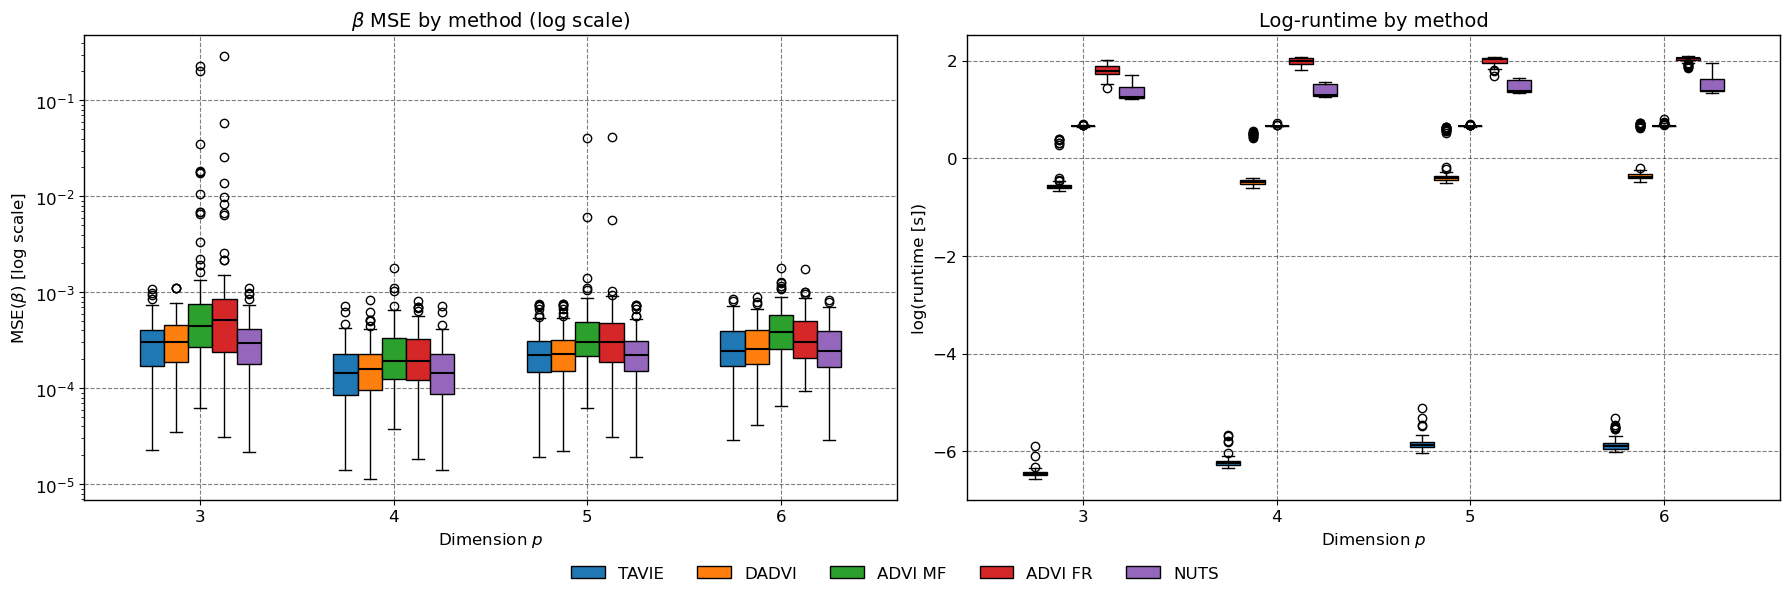

In [13]:
# plotting the results for TAVIE and competing methods over the choice of features p

methods   = ['TAVIE', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS']
colors    = ['C0',    'C1',    'C2',    'C3',     'C4']
P         = len(p_values)
M         = len(methods)

# --- spacing controls ---
group_spacing = 8.0      # distance between p-groups on the x-axis (↑ for bigger gaps)
method_step   = 1     # separation between methods within each group
box_width     = 1     # visual width of each box

centers = np.arange(P) * group_spacing  # group centers for each p

fig, axes = plt.subplots(1, 2, figsize=(18, 6), facecolor='white')
median_kws = dict(color='black', linewidth=1.5)

# Configure axes spines, ticks, grid
for ax in axes:
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(1.0)
    ax.tick_params(axis='both', colors='black', labelsize=12)
    ax.grid(True, color='black', linestyle='--', alpha=0.5)

# 2) β MSE (log scale)
ax = axes[0]
for j, arr in enumerate([mse_beta_TAVIE, mse_beta_DADVI, mse_beta_ADVI_mf, mse_beta_ADVI_fr, mse_beta_NUTS]):
    data = [arr[i, :] for i in range(P)]
    positions = centers + (j - (M-1)/2) * method_step
    bp = ax.boxplot(data, positions=positions, widths=box_width,
                    patch_artist=True, medianprops=median_kws)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')

ax.set_xticks(centers)
ax.set_xticklabels(p_values)
ax.set_yscale('log')
ax.set_xlabel('Dimension $p$', color='black', fontsize=12)
ax.set_ylabel(r'MSE($\beta$) [log scale]', color='black', fontsize=12)
ax.set_title(r'$\beta$ MSE by method (log scale)', color='black', fontsize=14)
ax.set_xlim(centers[0] - group_spacing*0.6, centers[-1] + group_spacing*0.6)

# 3) Runtime (log on the DATA; axis stays linear)
ax = axes[1]
for j, arr in enumerate([time_TAVIE, time_DADVI, time_ADVI_mf, time_ADVI_fr, time_NUTS]):
    data = [np.log(arr[i, :]) for i in range(P)]
    positions = centers + (j - (M-1)/2) * method_step
    bp = ax.boxplot(data, positions=positions, widths=box_width,
                    patch_artist=True, medianprops=median_kws)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')

ax.set_xticks(centers)
ax.set_xticklabels(p_values)
ax.set_xlabel('Dimension $p$', color='black', fontsize=12)
ax.set_ylabel('log(runtime [s])', color='black', fontsize=12)
ax.set_title('Log-runtime by method', color='black', fontsize=14)
ax.set_xlim(centers[0] - group_spacing*0.6, centers[-1] + group_spacing*0.6)

# Common legend below
handles = [Patch(facecolor=colors[i], edgecolor='black', label=methods[i]) for i in range(M)]
fig.legend(handles=handles, loc='lower center', ncol=M, frameon=False, fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 1])
fig.savefig(f'results_compete/plots/NegBin_metrics_multi_p_n_{n}.png', dpi=300, bbox_inches='tight')
plt.show()

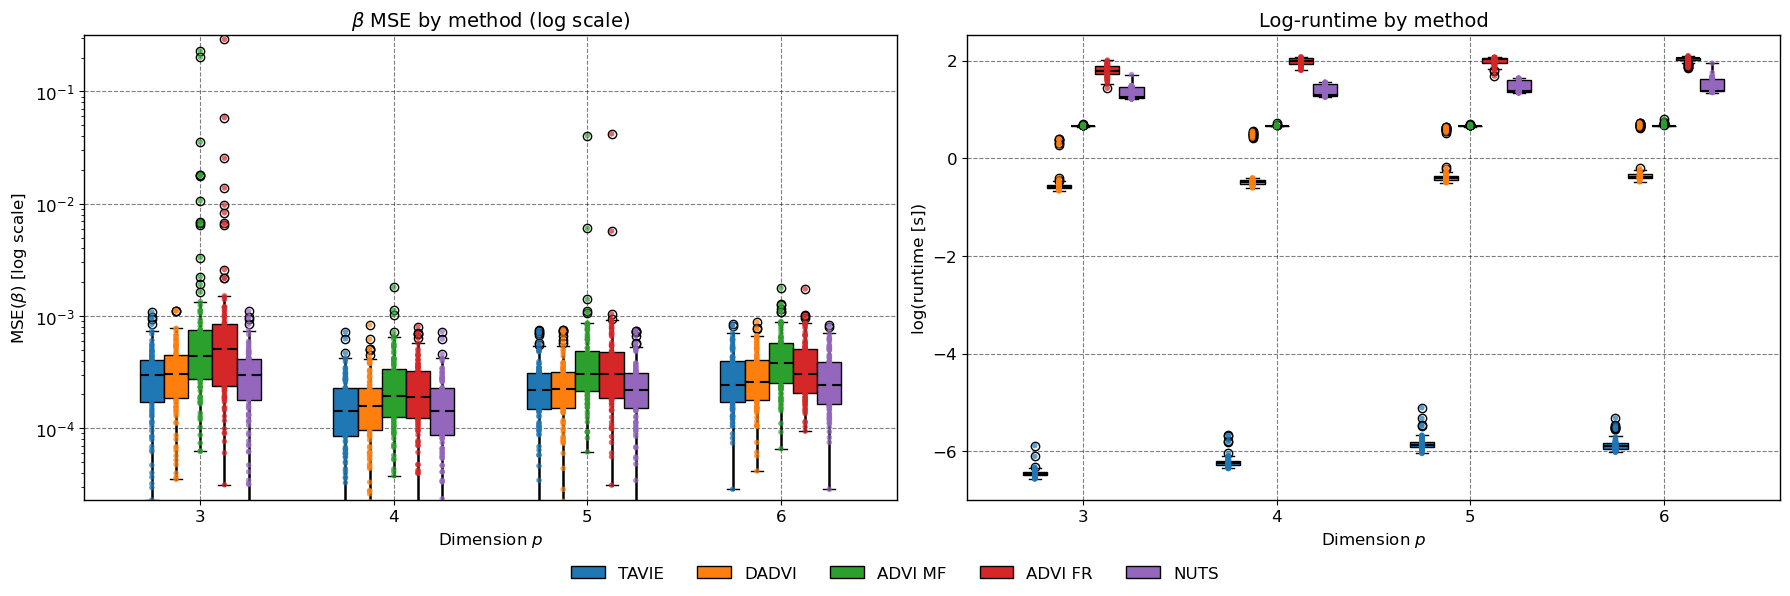

In [14]:
# --- METHODS & STYLES ---
methods = ['TAVIE', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS']
colors  = ['C0',    'C1',    'C2',      'C3',      'C4']
P       = len(p_values)
M       = len(methods)
eps     = 1e-16  # avoid log(0) on log-scale panels

# --- SPACING CONTROLS ---
group_spacing = 8.0    # gap between p-groups
method_step   = 1.0   # separation between methods within a group
box_width     = 1.0   # width of each box
centers       = np.arange(P) * group_spacing

fig, axes = plt.subplots(1, 2, figsize=(18, 6), facecolor='white')

# Axes styling
for ax in axes:
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_color('black'); spine.set_linewidth(1.0)
    ax.tick_params(axis='both', colors='black', labelsize=12)
    ax.grid(True, color='black', linestyle='--', alpha=0.5)

# Shared boxplot style (no whisker end caps)
bp_kwargs = dict(
    widths=box_width,
    patch_artist=True,
    whiskerprops=dict(linewidth=1.8, color='black'),
    medianprops=dict(linewidth=1.5, color='black'),
)

# ---------------- 2) β MSE (log axis) ----------------
ax = axes[0]
all_vals_beta = []
series_beta = [mse_beta_TAVIE, mse_beta_DADVI, mse_beta_ADVI_mf, mse_beta_ADVI_fr, mse_beta_NUTS]
for j, arr in enumerate(series_beta):
    data = [np.clip(arr[i, :], eps, None) for i in range(P)]  # ensure > 0
    positions = centers + (j - (M-1)/2) * method_step
    bp = ax.boxplot(data, positions=positions, **bp_kwargs)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')
    # overlay original values (clipped) (no jitter)
    for i in range(P):
        pos = positions[i]
        yvals = np.clip(np.asarray(arr[i, :]), eps, None)
        ax.scatter(np.full_like(yvals, pos, dtype=float), yvals,
                   s=16, alpha=0.7, color=colors[j], zorder=3, edgecolors='none')
        all_vals_beta.append(yvals)

ax.set_xticks(centers); ax.set_xticklabels(p_values)
ax.set_yscale('log')
ax.set_xlabel('Dimension $p$', fontsize=12)
ax.set_ylabel(r'MSE($\beta$) [log scale]', fontsize=12)
ax.set_title(r'$\beta$ MSE by method (log scale)', fontsize=14)
ax.set_xlim(centers[0] - group_spacing*0.6, centers[-1] + group_spacing*0.6)

# ---------------- 3) Runtime (log on data; linear axis) ----------------
ax = axes[1]
all_vals_time = []
series_time = [time_TAVIE, time_DADVI, time_ADVI_mf, time_ADVI_fr, time_NUTS]
for j, arr in enumerate(series_time):
    data = [np.log(np.clip(arr[i, :], eps, None)) for i in range(P)]
    positions = centers + (j - (M-1)/2) * method_step
    bp = ax.boxplot(data, positions=positions, **bp_kwargs)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')
    # overlay log-values (no jitter)
    for i in range(P):
        pos = positions[i]
        yvals = np.log(np.clip(np.asarray(arr[i, :]), eps, None))
        ax.scatter(np.full_like(yvals, pos, dtype=float), yvals,
                   s=16, alpha=0.7, color=colors[j], zorder=3, edgecolors='none')
        all_vals_time.append(yvals)

ax.set_xticks(centers); ax.set_xticklabels(p_values)
ax.set_xlabel('Dimension $p$', fontsize=12)
ax.set_ylabel('log(runtime [s])', fontsize=12)
ax.set_title('Log-runtime by method', fontsize=14)
ax.set_xlim(centers[0] - group_spacing*0.6, centers[-1] + group_spacing*0.6)

# ---------- Add headroom so nothing gets clipped ----------
if all_vals_beta:
    all_beta = np.concatenate(all_vals_beta)
    pos = all_beta[all_beta > 0]
    ymin = max(eps, np.percentile(pos, 0.5))
    ymax = pos.max() * 1.10
    axes[0].set_ylim(ymin, ymax)

if all_vals_time:
    all_time_log = np.concatenate(all_vals_time)  # already log()
    lo, hi = np.min(all_time_log), np.max(all_time_log)
    pad = 0.05 * (hi - lo) if hi > lo else 0.1
    axes[1].set_ylim(lo - pad, hi + pad)

# Legend
handles = [Patch(facecolor=colors[i], edgecolor='black', label=methods[i]) for i in range(M)]
fig.legend(handles=handles, loc='lower center', ncol=M, frameon=False, fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 1])
fig.savefig(f'results_compete/plots/NegBin_metrics_multi_p_n_{n}_other.png', dpi=300, bbox_inches='tight')
plt.show()